In [1]:
from unsloth import FastModel
import torch
import torch.nn as nn
from datasets import load_dataset
import re
from trl import GRPOConfig, GRPOTrainer
from transformers import (
    GPT2Model,
    GPT2Tokenizer,
    GPT2PreTrainedModel,
    GPT2Config,
    Trainer,
    TrainingArguments,
    AutoModelForCausalLM,
    TextStreamer
)
from typing import Dict, List
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import os
from tqdm import tqdm
from datasets import Dataset as HFDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import datetime
import time

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 05-04 08:27:36 [__init__.py:256] Automatically detected platform cuda.


In [3]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
class GPT2ForRegression(GPT2PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        # Load pre-trained GPT-2
        self.gpt2 = GPT2Model(config)
        
        # Add a custom regression head
        self.regression_head = nn.Sequential(
            nn.Dropout(config.resid_pdrop),
            nn.Linear(config.hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1)
        )
        
        # Initialize weights
        self.init_weights()
        
        # Freeze all GPT-2 parameters
        for param in self.gpt2.parameters():
            param.requires_grad = False
    
    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, 
                position_ids=None, head_mask=None, inputs_embeds=None, labels=None, **kwargs):
        
        # Get the output from GPT-2 base model
        with torch.no_grad():  # Ensure no gradients flow through GPT-2
            outputs = self.gpt2(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,
                position_ids=position_ids,
                head_mask=head_mask,
                inputs_embeds=inputs_embeds
            )
        
        # Get the last hidden state
        sequence_output = outputs[0]
        
        # Use the last token's representation
        batch_size = sequence_output.shape[0]
        last_token_ids = attention_mask.sum(dim=1) - 1
        last_token_ids = last_token_ids.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, sequence_output.size(-1))
        last_token_output = torch.gather(sequence_output, 1, last_token_ids).squeeze(1)
        
        # Pass through regression head
        logits = self.regression_head(last_token_output).squeeze(-1)
        
        loss = None
        if labels is not None:
            loss_fct = nn.MSELoss()
            loss = loss_fct(logits.view(-1), labels.view(-1))
        
        return {"loss": loss, "logits": logits} if loss is not None else {"logits": logits}

In [5]:
def load_reward_model(model_path):
    """Load the saved reward model"""
    print(f"Loading reward model from {model_path}")
    tokenizer = GPT2Tokenizer.from_pretrained(model_path)
    tokenizer.pad_token = tokenizer.eos_token
    # Create the model
    model = GPT2ForRegression.from_pretrained(model_path)
    # Set model to eval mode
    model.eval()
    model.to(device)  
    return model, tokenizer

In [6]:
# Path to your saved model - adjust this to your actual model path
reward_model_path = "./gpt2-reward-model-frozen"

# Load the model
reward_model, reward_tokenizer = load_reward_model(reward_model_path)

Loading reward model from ./gpt2-reward-model-frozen


In [7]:
class RewardFunction:
    def __init__(self, model, tokenizer, device="cuda" if torch.cuda.is_available() else "cpu"):
        self.model = model.to(device)
        self.tokenizer = tokenizer
        self.device = device
        self.model.eval()
        print(f"Reward function initialized on device: {device}")
    
    def __call__(self, query_text: List[str], response_text: List[str]) -> torch.Tensor:
        """
        Calculate rewards for each query-response pair
        
        Args:
            query_text: List of query/instruction strings
            response_text: List of response strings
            
        Returns:
            torch.Tensor of rewards
        """
        rewards = []
        
        for query, response in zip(query_text, response_text):
            # Format the input as "Question: {query} Answer: {response}"
            formatted_text = f"Question: {query} Answer: {response}"
            
            # Tokenize
            inputs = self.tokenizer(
                formatted_text,
                return_tensors="pt",
                padding="max_length",
                truncation=True,
                max_length=512
            ).to(self.device)
            
            # Get model prediction
            with torch.no_grad():
                outputs = self.model(**inputs)
                reward = outputs["logits"].item()
            
            rewards.append(reward)
        
        return torch.tensor(rewards, device=self.device)

# Initialize the reward function
reward_fn = RewardFunction(reward_model, reward_tokenizer)

Reward function initialized on device: cuda


In [8]:
# Non list implementation
class RewardFunction:
    def __init__(self, model, tokenizer, device="cuda" if torch.cuda.is_available() else "cpu"):
        self.model = model.to(device)
        self.tokenizer = tokenizer
        self.device = device
        self.model.eval()
        print(f"Reward function initialized on device: {device}")
    
    def __call__(self, query_text: str, response_text: str) -> torch.Tensor:
        """
        Calculate rewards for each query-response pair
        
        Args:
            query_text: List of query/instruction strings
            response_text: List of response strings
            
        Returns:
            torch.Tensor of rewards
        """
        formatted_text = f"Question: {query_text} Answer: {response_text}"
        # Tokenize
        inputs = self.tokenizer(
            formatted_text,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=512
        ).to(self.device)
        with torch.no_grad():
            outputs = self.model(**inputs)
            reward = outputs["logits"].item()
        return torch.tensor(reward, device=self.device)


# Initialize the reward function
reward_fn = RewardFunction(reward_model, reward_tokenizer)

Reward function initialized on device: cuda


Test rewards: tensor(0.5080, device='cuda:0')


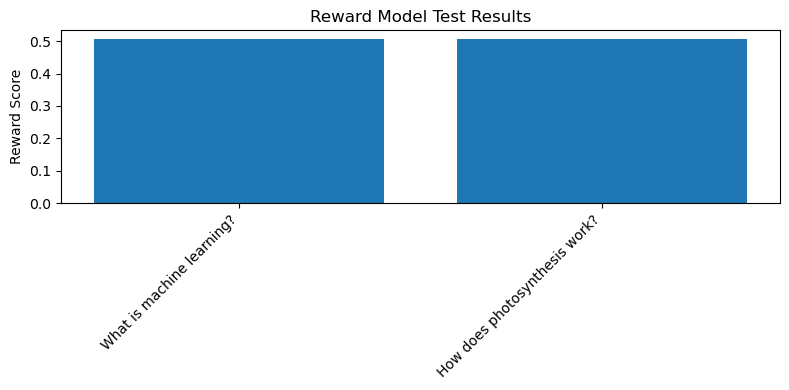

In [9]:
# Test the reward function with some example data
test_queries = [
    "What is machine learning?",
    "How does photosynthesis work?"
]

test_responses = [
    "Machine learning is a field of artificial intelligence that enables computers to learn from data without being explicitly programmed.",
    "Photosynthesis is the process where plants convert sunlight, water, and carbon dioxide into oxygen and glucose for energy."
]

# Get rewards for test data
rewards = reward_fn(test_queries[0], test_responses[0])
print("Test rewards:", rewards)

# Visualize the rewards
plt.figure(figsize=(8, 4))
plt.bar(range(len(test_queries)), rewards.cpu().numpy())
plt.xticks(range(len(test_queries)), test_queries, rotation=45, ha='right')
plt.ylabel('Reward Score')
plt.title('Reward Model Test Results')
plt.tight_layout()
plt.show()

In [10]:
dataset = load_dataset("stanfordnlp/shp",  split='train[:1%]')
dataset

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

Dataset({
    features: ['post_id', 'domain', 'upvote_ratio', 'history', 'c_root_id_A', 'c_root_id_B', 'created_at_utc_A', 'created_at_utc_B', 'score_A', 'score_B', 'human_ref_A', 'human_ref_B', 'labels', 'seconds_difference', 'score_ratio'],
    num_rows: 3487
})

In [ ]:
# Format Dataset for GRPO Trainer
dataset_rew = dataset.map(lambda x: {
    "prompt" : x['history'],
    "chosen": x['human_ref_A'] if x['labels'] == 1 else x['human_ref_B'],
    "rewards": reward_fn( x['history'], x['human_ref_A'] if x['labels'] == 1 else x['human_ref_B'])
})
dataset_rew[0]

Map:   0%|          | 0/3487 [00:00<?, ? examples/s]

In [ ]:
# Create reward function that passes the prompt and answer to our finetuned GPT2 to predict the glicko score - volatility
def gpt_reward(prompts, completions, rewards, **kwargs):
    return rewards
        

In [ ]:
max_seq_length = 1024

fourbit_models = [
    # 4bit dynamic quants for superior accuracy and low memory use
    "unsloth/gemma-3-1b-it-unsloth-bnb-4bit",
    "unsloth/gemma-3-4b-it-unsloth-bnb-4bit",
    "unsloth/gemma-3-12b-it-unsloth-bnb-4bit",
    "unsloth/gemma-3-27b-it-unsloth-bnb-4bit",

    # Other popular models!
    "unsloth/Llama-3.1-8B",
    "unsloth/Llama-3.2-3B",
    "unsloth/Llama-3.3-70B",
    "unsloth/mistral-7b-instruct-v0.3",
    "unsloth/Phi-4",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastModel.from_pretrained(
    model_name = "unsloth/gemma-3-1b-it",
    max_seq_length = max_seq_length, # Choose any for long context!
    load_in_4bit = False,  # 4 bit quantization to reduce memory
    load_in_8bit = False, # [NEW!] A bit more accurate, uses 2x memory
    full_finetuning = False, # [NEW!] We have full finetuning now!
    # token = "hf_...", # use one if using gated models
)

In [ ]:
model = FastModel.get_peft_model(
    model,
    finetune_vision_layers     = False, # Turn off for just text!
    finetune_language_layers   = True,  # Should leave on!
    finetune_attention_modules = True,  # Attention good for GRPO
    finetune_mlp_modules       = True,  # SHould leave on always!

    r = 8,           # Larger = higher accuracy, but might overfit
    lora_alpha = 8,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
)

In [ ]:
# Ensure proper padding token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
max_prompt_length = 256
max_seq_length = 1024
# Configure GRPO - adjust based on your GPU memory
training_args = GRPOConfig(
    learning_rate = 5e-6,
    adam_beta1 = 0.9,
    adam_beta2 = 0.99,
    weight_decay = 0.1,
    warmup_ratio = 0.1,
    lr_scheduler_type = "cosine",
    optim = "adamw_torch_fused",
    logging_steps = 1,
    per_device_train_batch_size =2,
    gradient_accumulation_steps = 1, # Increase to 4 for smoother training
    num_generations = 2, # Decrease if out of memory
    max_prompt_length = max_prompt_length,
    max_completion_length = max_seq_length - max_prompt_length,
    num_train_epochs = 1, # Set to 1 for a full training run
    max_steps = 25,
    save_steps = 50,
    max_grad_norm = 0.1,
    report_to = "none", # Can use Weights & Biases
    output_dir = "outputs",
)

In [ ]:
trainer = GRPOTrainer(
        model=model,
        tokenizer=tokenizer,
        args=training_args,
        train_dataset=dataset_rew,
        reward_funcs=gpt_reward  # This is the correct place for the reward_model parameter
    )

In [ ]:
trainer.train()

In [ ]:
# Save the model to a local directory
output_path = "gemma_glicko"
trainer.save_model(output_path)
print(f"Model saved to {output_path}")